In [1]:
import sys, os
sys.path.append('../src')
import numpy as np
from scipy import interpolate
from numba import jit, float64
import time, multiprocessing, pickle
from U1Funcs import DMvRatesGen
from StatisticFuncs import *
from WIMPFuncs import C_SI
from Params import *
from U1PlotFuncs import *

In [2]:
#========================== Experimental setup =========================================#
ne = 10 
E_th = 1*1e-2*1e-6 # Threshold
E_max = 8*1e-6 # Max recoil energy
Nuc = Xe131
#========================== Energy transition function for CEvNS =========================================#
myPath = os.path.join(os.path.abspath(os.path.pardir),'data','detection')
ERList, ionLow, ionFiducial, ionHigh = np.loadtxt(os.path.join(myPath,'ionXenonDat.csv'),delimiter=',')
neERFunc = np.vectorize(interpolate.interp1d(ERList,ionFiducial))
#========================== DM-electron Rates =========================================#
temp = np.loadtxt(os.path.join(myPath,'DMElectronStandard.csv'),delimiter=',')
mDMList = temp[:,0]
DMElectronStandardList = temp[:,1:11]
#========================== Initialize fog =========================================#
fogGen=Fog()
#========================== Model and other parameters =========================================#
selList=np.array([1,3]) # only 8B and hep neutrinos are considered
thresholdBin=3
b0Level=0.
mDM = 0.1

In [3]:
modelParaList = [[np.log10(2e-5),np.log10(30e-3),1,1,1],\
    [np.log10(4e-5),np.log10(20e-3),1/3,1/3,-1], [np.log10(8e-4),np.log10(16e-3),[0,1,-1]]]
paraGenList = [StatisticClass(SpectrumER(mDMList, DMElectronStandardList, neERFunc, \
            E_th, E_max, ne, Nuc,modelParaList[0], selList, thresholdBin), 'SMvsDMNP'),\
               StatisticClass(SpectrumER(mDMList, DMElectronStandardList, neERFunc, \
            E_th, E_max, ne, Nuc,modelParaList[1], selList, thresholdBin), 'DMvsNP'),\
               StatisticClass(SpectrumER(mDMList, DMElectronStandardList, neERFunc, \
            E_th, E_max, ne, Nuc,modelParaList[2], selList, thresholdBin=thresholdBin,mode='FD'), 'DMvsNP')]

[['0' 'pep']
 ['1' 'hep']
 ['2' '7Be2']
 ['3' '8B']
 ['4' '13N']
 ['5' '15O']
 ['6' '17F']
 ['7' 'DSNB']
 ['8' 'Atm']
 ['9' 'GeoU']
 ['10' 'GeoTh']
 ['11' 'GeoK']
 ['12' 'Reactor']]
[['0' 'pep']
 ['1' 'hep']
 ['2' '7Be2']
 ['3' '8B']
 ['4' '13N']
 ['5' '15O']
 ['6' '17F']
 ['7' 'DSNB']
 ['8' 'Atm']
 ['9' 'GeoU']
 ['10' 'GeoTh']
 ['11' 'GeoK']
 ['12' 'Reactor']]
[['0' 'pep']
 ['1' 'hep']
 ['2' '7Be2']
 ['3' '8B']
 ['4' '13N']
 ['5' '15O']
 ['6' '17F']
 ['7' 'DSNB']
 ['8' 'Atm']
 ['9' 'GeoU']
 ['10' 'GeoTh']
 ['11' 'GeoK']
 ['12' 'Reactor']]


In [4]:
def myMul2(mDM, paraGenClass, FogGenClass, modelPara):
    exposureEndLog, dExpoLog, CL, b0Level = 8., 0.1, 0.9, 0.
    paraGenClass.setModel(modelPara)
    paraGenClass.setDMMass(mDM)
    NPDiscoveryExposure = biSearch(1., 8, findNPDiscoveryExposure, [paraGenClass, CL, b0Level], 0., 0)[0]
    #print([modelPara,NPDiscoveryExposure])
    paraList = exposureEndLog, dExpoLog, CL, b0Level, NPDiscoveryExposure
    return myMul(mDM, paraGenClass, FogGenClass, paraList)

# linux
# def resGen2(mDM, paraGenClass, FogGenClass, modelParaList):
#     time_start = time.perf_counter()
#     pool = multiprocessing.Pool(4)
#     multiple_results = [pool.apply_async(\
#             myMul2, [mDM, paraGenClass, FogGenClass, modelPara]) for modelPara in modelParaList]
#     pool.close()
#     pool.join()
#     res1= [res.get() for res in multiple_results]
#     time_end = time.perf_counter()
#     print("Time costed: {0} s.".format(time_end-time_start))
    
#     res1 = [item for item in res1]
#     modelMassList = 10**np.array([d[1] for d in modelParaList])
#     return [modelMassList, res1]

# windows
from joblib import Parallel, delayed
from tqdm import tqdm

def resGen2(mDM, paraGenClass, FogGenClass, modelParaList, n_jobs=20):
    time_start = time.perf_counter()

    # Define the function to be parallelized
    def parallel_function(modelPara, mDM, paraGenClass, FogGenClass):
        return myMul2(mDM, paraGenClass, FogGenClass, modelPara)

    # Use joblib to parallelize the computation and visualize the progress with tqdm
    results = Parallel(n_jobs=n_jobs)(delayed(parallel_function)(modelPara, mDM, paraGenClass, FogGenClass) for modelPara in tqdm(modelParaList))

    time_end = time.perf_counter()
    print("Time costed: {0} s.".format(time_end - time_start))

    modelMassList = 10**np.array([d[1] for d in modelParaList])
    return [modelMassList, results]

In [5]:
myPath = os.path.join(os.path.abspath(os.path.pardir),'data','detection')
U1UniversalLimitDat=np.transpose(np.log10(np.loadtxt(os.path.join(myPath,'U(1)UniversalLimit.txt'))))
U1UniversalLimitFunc = lambda mLog: np.interp(mLog, U1UniversalLimitDat[0], U1UniversalLimitDat[1])
U1BLLimitDat=np.transpose(np.log10(np.loadtxt(os.path.join(myPath,'U(1)BL.txt'))))
U1BLLimitFunc = lambda mLog: np.interp(mLog, U1BLLimitDat[0], U1BLLimitDat[1])
U1LmuLtauLimitDat=np.transpose(np.log10(np.loadtxt(os.path.join(myPath,'U(1)LmuLtau.txt'))))
U1LmuLtauLimitFunc = lambda mLog: np.interp(mLog, U1LmuLtauLimitDat[0], U1LmuLtauLimitDat[1])
[10**U1UniversalLimitFunc(np.log10(20e-3)),10**U1BLLimitFunc(np.log10(20e-3)),\
    10**U1LmuLtauLimitFunc(np.log10(20e-3))]

[2.2854831587645412e-05, 5.027088693857333e-05, 0.0009166954315114784]

In [6]:
colorList = ['r', 'b', 'g']
labelList = [r'U(1)$_{\rm Universal}$', r'U(1)$_{B-L}$',r'U(1)$_{L_\mu-L_\tau}$']

In [7]:
mLogList = np.linspace(np.log10(16e-3),np.log10(200e-3),40)
modelParaListUniversal = [[U1UniversalLimitFunc(mLog), mLog, 1,1,1] for mLog in mLogList]
resListUniversal = resGen2(mDM, paraGenList[0], fogGen, modelParaListUniversal)

100%|██████████| 40/40 [00:32<00:00,  1.24it/s] 


Time costed: 50.940175499999896 s.


In [8]:
mLogList = np.linspace(np.log10(16e-3),np.log10(200e-3),40)
modelParaListBL = [[U1BLLimitFunc(mLog), mLog, 1/3,1/3,-1] for mLog in mLogList]
resListBL = resGen2(mDM, paraGenList[1], fogGen, modelParaListBL)

100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Time costed: 36.288381099991966 s.


In [9]:
mLogList = np.linspace(np.log10(16e-3),np.log10(50e-3),20)
modelParaListLmuLtau = [[U1LmuLtauLimitFunc(mLog), mLog, [0,1,-1]] for mLog in mLogList]
resListLmuLtau = resGen2(mDM, paraGenList[2], fogGen, modelParaListLmuLtau)

100%|██████████| 20/20 [00:00<00:00, 19996.68it/s]


Time costed: 15.446405700000469 s.


In [10]:
[maxCheck(res[0], res[1]) for res in [resListUniversal, resListBL, resListLmuLtau]]

[array([5.47661284e-02, 2.41115062e-42, 2.82897827e+00]),
 array([1.70704858e-02, 2.02166201e-41, 6.54361022e+00]),
 array([1.80388754e-02, 2.41115062e-42, 3.19536695e+00])]

In [11]:
PandaX4TLimitDat =np.transpose(loadtxt("../data/WIMPLimits/DM-e constant/PandaX-4T DM-e constant.txt"))
PandaX4TLimitFunc = lambda mDM: np.interp(mDM, PandaX4TLimitDat[0], PandaX4TLimitDat[1])
PandaX4TLimitFunc(1e-1)

2.867132881897227e-41

In [12]:
def ax1Func2(ax1, dat, color, label=False, rightLabel=False):
    n = 4
    colors = np.zeros([n,4])
    colors[0] = mpl.colors.to_rgba(color)
    colors[:] = mpl.colors.to_rgba(color)
    colors[:,3] = [0., 0.2, 0.5, 0.8]
    cmap = mpl.colors.ListedColormap(colors, name='test')
    m,sig,n = vsContourDatGen(dat[0], dat[1])
    cnt = ax1.contourf(m*1e3,sig,n,np.array([1., 2., 3., 4.,10000.]),\
                       colors=colors,antialiased=True)
    if label!=False:
        ax1.fill_between([-2,-1],[1,1],[2,2],color=color,alpha=0.5,label=label)
    # for c in cnt.collections:
    #     c.set_edgecolor(color)
    cnt.collections[1].set_edgecolor(color)
    if rightLabel:
        cmap2 = mpl.colors.ListedColormap(colors[1:-1], name='test')
        cmap2.set_under(color=color, alpha=0.)
        cmap2.set_over(color=color, alpha=0.8)
        im = plt.pcolormesh(-m,sig,n,vmax=3.,vmin=1,cmap=cmap2,rasterized=True,shading='auto')
        #fig.subplots_adjust(top=0.8)
        cbar_ax = fig.add_axes([0.912, 0.12, 0.03, 0.74])
        cbar = fig.colorbar(im, cax=cbar_ax,orientation='vertical',extend='max',extendfrac=0.08, \
                     ticks=[2,3,4])
        cbar.set_ticklabels([2.,3.,4.])
        cbar_ax.yaxis.set_ticks_position('right')
        #plt.gcf().text(0.5,0.883,r'$n = {\rm Exposure}_{\rm Distinction}/{\rm Exposure}_{\rm Discovery}$',fontsize=22,ha='center')


C:\Users\ALoong\AppData\Local\Temp\ipykernel_15264\3974331999.py:15: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  cnt.collections[1].set_edgecolor(color)
C:\Users\ALoong\AppData\Local\Temp\ipykernel_15264\3974331999.py:15: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  cnt.collections[1].set_edgecolor(color)


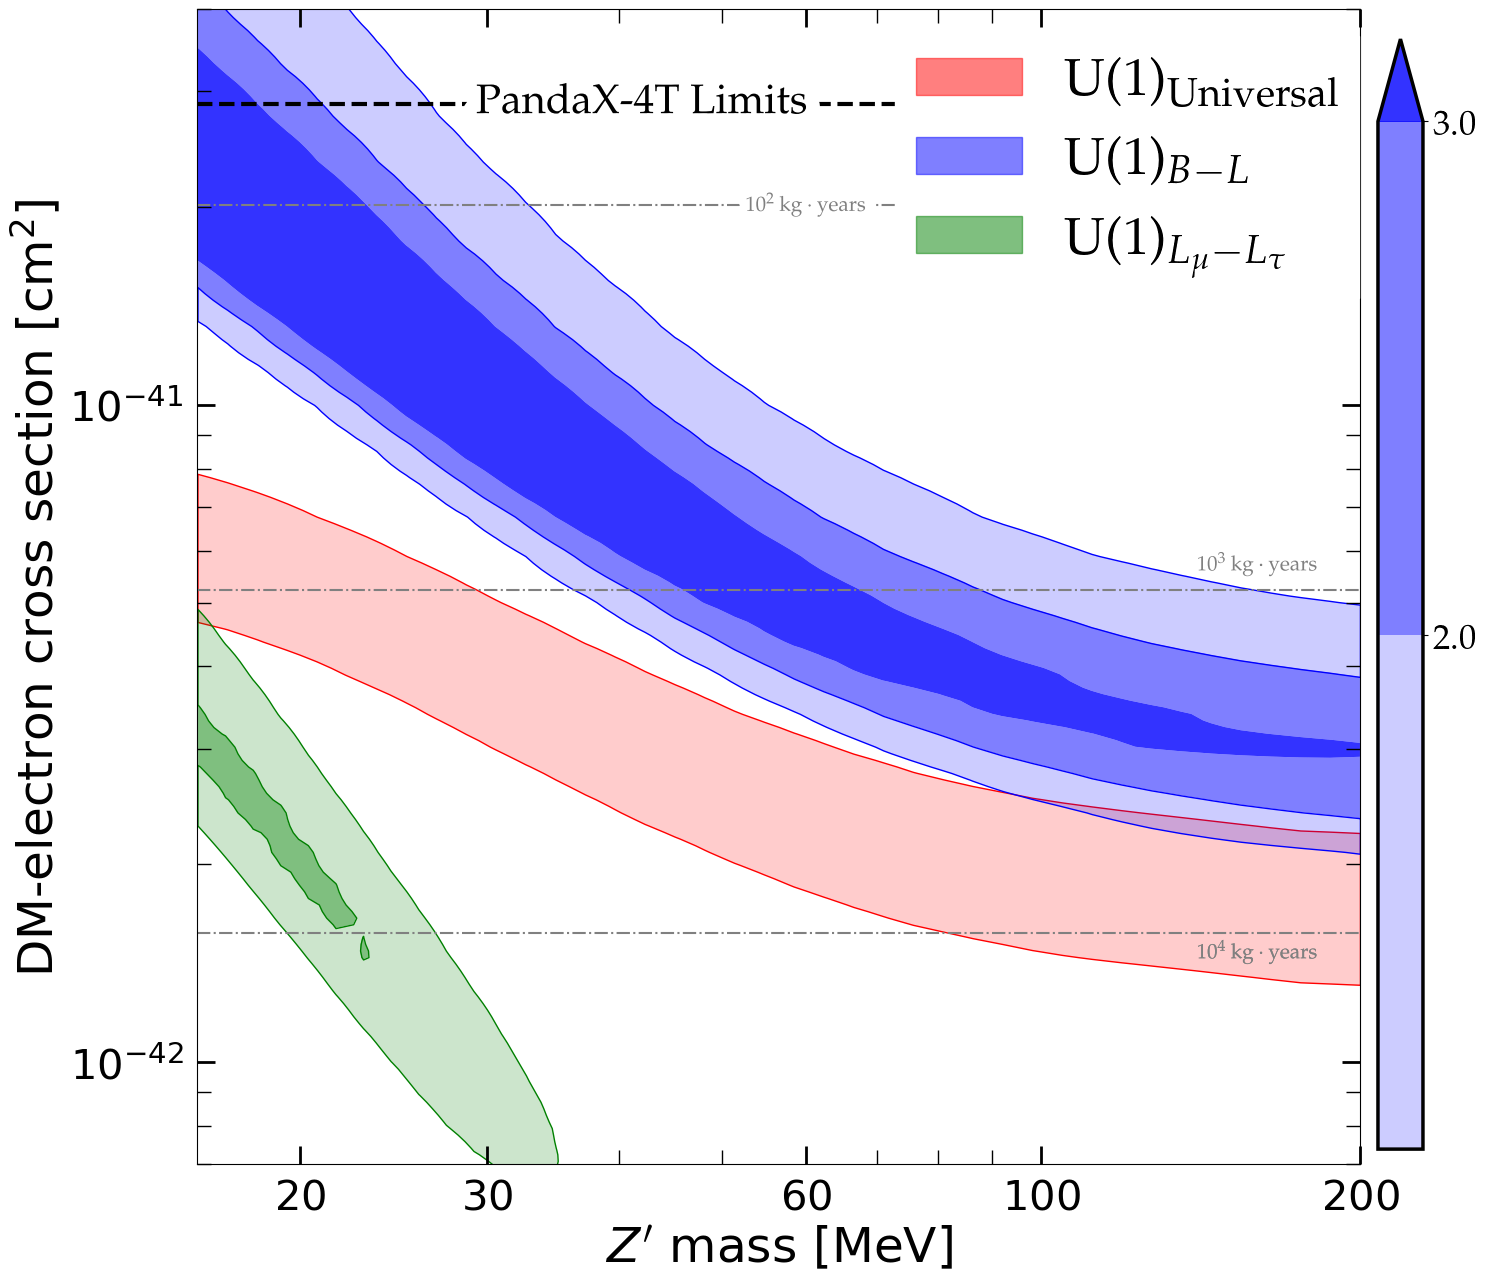

In [13]:
resList = [resListUniversal, resListBL, resListLmuLtau]

fig, ax1 = plt.subplots(figsize=(15,15))
# Plot style
lw, tfs = 2.5, 25
lfs = 35
plt.rcParams['axes.linewidth'] = lw
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=tfs)
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathpazo}'
#========================== exposure ============================================#
expoLogList = np.linspace(1,4,4)
sigma0ContourList = 10**np.transpose([np.interp(expoLogList, d[1][1], d[1][0]) for d in resList[0][1]])
expoLogLabelList = [r"$10^"+str(i)+r"$ ${\rm kg}\cdot {\rm years}$" \
                                                          for i in range(2,5)]
lines=[]
for i in range(len(expoLogLabelList)):
    l1 = ax1.loglog(resList[0][0]*1e3, sigma0ContourList[i], c='gray', linestyle='-.', label=expoLogLabelList[i])
    lines.extend(l1)

labelLines([lines[0]], xvals=60, fontsize=15, outline_width=13,drop_label=True)
labelLines([lines[1]], xvals=160, fontsize=15, outline_width=8,drop_label=True,yoffsets=5e-43)
labelLines([lines[2]], xvals=160, fontsize=15, outline_width=0,drop_label=True,yoffsets=-1e-43)
#========================== experiment ==========================================#
pek = line_background(7,'k')
l1=ax1.axhline(PandaX4TLimitFunc(1e-1),c='black',lw=3,linestyle='--',label=r"PandaX-4T Limits")
labelLines([l1], xvals=42, fontsize=30, outline_width=20,drop_label=True)
#========================== contour plot ========================================#
ax1Func2(ax1, resList[0], colorList[0],label=labelList[0])
ax1Func2(ax1, resList[1], colorList[1],label=labelList[1], rightLabel=True)
ax1Func2(ax1, resList[2], colorList[2],label=labelList[2])
ZprimeMassList = resList[0][0]*1e3
#========================== style ===============================================#
ax1.legend(fontsize=38,frameon=True,loc=(0.6,0.75),framealpha=1,fancybox=False,edgecolor=[1,1,1,0])
ax1.set_xlabel(r"$Z^\prime$ mass [MeV]",fontsize=lfs)
ax1.set_ylabel(r"DM-electron cross section [cm$^2$]",fontsize=lfs)
ax1.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=10,labelsize=30)
ax1.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)
ax1.set_yticks(10.0**np.arange(-51,-30,1))
ax1.set_xlim(left=ZprimeMassList[0], right=ZprimeMassList[-1])
ax1.set_ylim(bottom=7e-43, top=4e-41)
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.xaxis.set_major_locator(mticker.FixedLocator([2e1,3e1,6e1,1e2,2e2]))
ax1.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
#ax1.ticklabel_format(axis='x',style='sci')

In [14]:
myPathFig = os.path.join(os.path.abspath(os.path.pardir),'plots')
fig.savefig(os.path.join(myPathFig,"DMeConstant_U1"+'.pdf'),bbox_inches='tight')
fig.savefig(os.path.join(myPathFig,'png','DMeConstant_U1.png'),bbox_inches='tight')